In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def nice_plot(ax):
    ax.set(xlabel="$x$", ylabel="Probability")
    ax.axhline(0, color="k")
    ax.axvline(0, color="k")
    ax.grid(alpha=0.5)

### 5.2 Model predicting weights

In [3]:
# a) Make a linear model that takes one input, x, and outputs three values.
class Model(torch.nn.Module):
    def __init__(self, n_features=1, n_classes=3):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n_classes)
    
    def forward(self, x):
        x = x.view(-1, 1)
        x = self.fc1(x)
        return x

In [4]:
# b) Set the three weights in the model to 0.7, 0.25, and 0.9, respectively and the three biases to 1, − 0.4, and 0.5
model = Model()
model.fc1.weight.data[...] = torch.tensor([[0.7], [0.25], [0.9]])
model.fc1.bias.data[...] = torch.tensor([1, -0.4, 0.5])

In [5]:
# c) Check that the parameters are set correctly by obtaining them from the model and writing them out:
for name, parameters in model.named_parameters():
    print(name,parameters)

fc1.weight Parameter containing:
tensor([[0.7000],
        [0.2500],
        [0.9000]], requires_grad=True)
fc1.bias Parameter containing:
tensor([ 1.0000, -0.4000,  0.5000], requires_grad=True)


In [6]:
# d) Setup a tensor, test_P, with seven x x-values from -6 to 6:
test_P = torch.tensor(np.arange(-6, 8, 2), dtype=torch.float32)
print(test_P)

tensor([-6., -4., -2.,  0.,  2.,  4.,  6.])


In [7]:
# e) Pass the tensor to the network and check that it predicts these weights:
predicted_weights = model(test_P)
print(predicted_weights)

tensor([[-3.2000, -1.9000, -4.9000],
        [-1.8000, -1.4000, -3.1000],
        [-0.4000, -0.9000, -1.3000],
        [ 1.0000, -0.4000,  0.5000],
        [ 2.4000,  0.1000,  2.3000],
        [ 3.8000,  0.6000,  4.1000],
        [ 5.2000,  1.1000,  5.9000]], grad_fn=<AddmmBackward0>)


### 5.3 Softmax

In [8]:
# f) Implement a softmax function f according to the formula:
def f(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1).view(-1, 1)

predicted_probabilities = f(predicted_weights)
print(predicted_probabilities)

tensor([[0.2061, 0.7562, 0.0377],
        [0.3617, 0.5397, 0.0986],
        [0.4967, 0.3013, 0.2020],
        [0.5396, 0.1331, 0.3273],
        [0.4987, 0.0500, 0.4513],
        [0.4183, 0.0171, 0.5646],
        [0.3300, 0.0055, 0.6645]], grad_fn=<DivBackward0>)


In [9]:
# g) Check that with the PyTorch-function torch.softmax you get the same probabilities:
predicted_probabilities_torch = torch.softmax(predicted_weights, dim=1)
print(predicted_probabilities_torch)

tensor([[0.2061, 0.7562, 0.0377],
        [0.3617, 0.5397, 0.0986],
        [0.4967, 0.3013, 0.2020],
        [0.5396, 0.1331, 0.3273],
        [0.4987, 0.0500, 0.4513],
        [0.4183, 0.0171, 0.5646],
        [0.3300, 0.0055, 0.6645]], grad_fn=<SoftmaxBackward0>)


### 5.4 Cross-entropy
Our network is not trained yet, and its weights that we just turned into probabilities using softmax are basically just random. Nonetheless, call the probability distribution that the network codes for: $Q$. Later in this exercise, we will have some observations, that stem from another distribution, $P$, and minimizing the cross-entropy, $H(P, Q)$, by optimizing the model parameters will lead to the neural network model learning to provide weights that code for $P$. However, we start by asking the question:

What are, according to $Q$, the most likely observations for $x \in {x_1, x_2, \dots , x_N}$?

Cross entropy:
$$ H(P,Q) = -\sum_\text{label}\int P(x, \text{label}) \log(Q(x, \text{label})) \,\mathrm{d}x, $$
where $x$ is the independent variable, and label runs over the three possible values (e.g. 0, 1, and 2).

With $P$ known via observations, the cross-entropy is given by
$$ H(P,Q) \approx -\frac{1}{N}\sum_{i=1}^N \log(Q(x_i, \text{label}_i)) $$

In [10]:
# h) Minimize H(P,Q) with respect to {label_1, label_2, ..., label_N } for [x_1, x_2,... ,x_N] = test_P
def cross_entropy_from_probabilities(probabilities, guessed_labels):
    probabilities_for_guessed_labels = torch.gather(probabilities,
                                                    dim=1,
                                                    index=guessed_labels.unsqueeze(1))
    return torch.mean(-torch.log(probabilities_for_guessed_labels))

for _ in range(10):
    guessed_labels = torch.randint(0, 3, (7,))
    cross_entropy = cross_entropy_from_probabilities(predicted_probabilities, guessed_labels)
    print(cross_entropy, guessed_labels)

tensor(0.6555, grad_fn=<MeanBackward0>) tensor([1, 0, 0, 0, 0, 0, 2])
tensor(1.8270, grad_fn=<MeanBackward0>) tensor([0, 2, 2, 1, 2, 1, 2])
tensor(1.5412, grad_fn=<MeanBackward0>) tensor([1, 0, 2, 2, 0, 0, 1])
tensor(1.0270, grad_fn=<MeanBackward0>) tensor([1, 2, 1, 0, 2, 0, 0])
tensor(1.5698, grad_fn=<MeanBackward0>) tensor([0, 2, 0, 2, 2, 1, 2])
tensor(1.7270, grad_fn=<MeanBackward0>) tensor([0, 0, 2, 1, 0, 1, 0])
tensor(1.5555, grad_fn=<MeanBackward0>) tensor([0, 1, 0, 1, 2, 1, 0])
tensor(1.4984, grad_fn=<MeanBackward0>) tensor([0, 1, 0, 2, 0, 2, 1])
tensor(1.7841, grad_fn=<MeanBackward0>) tensor([2, 1, 2, 2, 0, 1, 0])
tensor(0.8127, grad_fn=<MeanBackward0>) tensor([1, 0, 1, 2, 2, 0, 2])


In [11]:
# i) Now use PyTorch to calculate the cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()
criterion(predicted_weights, torch.tensor([1, 1, 0, 0, 0, 2, 2], dtype=torch.long))

tensor(0.5555, grad_fn=<NllLossBackward0>)

### 5.5 Model predictions of label
In the last question, you varied the possibly observed labels in order to minimize the cross-entropy for a fixed model. This led to the most likely observed labels. But honestly, those labels can be obtained in a much easier way: You can simply find the label with the largest predicted probability for each input, $x_i$.

In [12]:
# j) Extend the model with a method to predict the labels.
class Model(torch.nn.Module):
    def __init__(self, n_features=1, n_classes=3):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n_classes)

    def forward(self, x):
        x = x.view(-1, 1)
        x = self.fc1(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

# k) Check that you get the same labels as in the cross-entropy optimization
model = Model()
predicted_labels = model.predict_label(test_P)
print(predicted_labels)

tensor([0, 0, 1, 1, 1, 1, 1])


c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


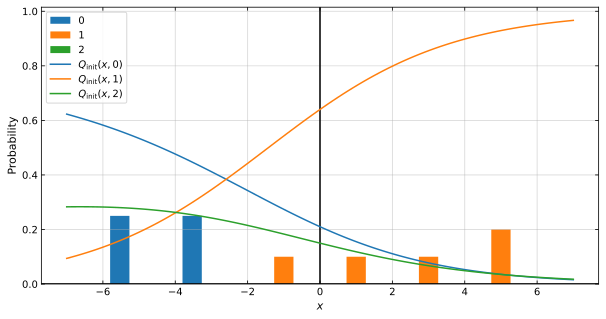

In [13]:
# Plot them in a histogram. Include in the plot three curves Q_init(x, label), for the probabilities of the three different labels as predicted by the yet untrained neural network.
fig, ax = plt.subplots(figsize=(10,5))
nice_plot(ax)
ax.hist([test_P[predicted_labels == i] for i in range(3)], bins=np.arange(-6, 8, 2), density=True, label=[f"{i}" for i in range(3)], color=["C0", "C1", "C2"])

xs = torch.linspace(-7, 7, 100)
with torch.no_grad():
    for label in range(3):
        ys = torch.softmax(model(xs), dim=1)[:, label]
        ax.plot(xs, ys, label=fr"$Q_\mathrm{{init}}(x, {label})$", color=f"C{label}")

ax.legend()

fig.savefig('ex55_fig1.png')

### 5.6 Optimize model

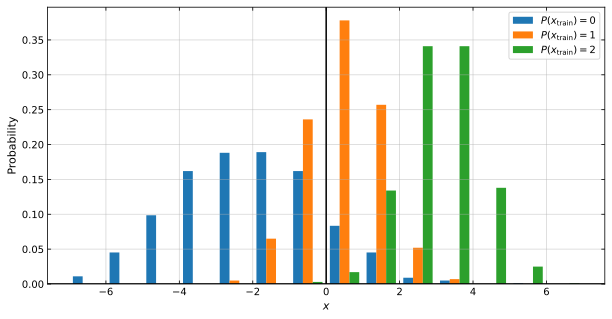

In [14]:
# i) Draw data from three normal distributions to train the model
sigmas = np.array([2, 1, 1]).reshape(-1, 3)
x0s = np.array([-2., 0.5, 3.]).reshape(-1, 3)
stacked_points = sigmas*np.random.randn(1000, 3) + x0s

fig, ax = plt.subplots(figsize=(10,5))
nice_plot(ax)
ax.hist(stacked_points, bins=np.arange(-7, 8, 1), density=True, label=[fr"$P(x_\mathrm{{train}}) = {i}$" for i in range(3)], color=["C0", "C1", "C2"])
ax.legend()

fig.savefig('ex55_fig2.png')

c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


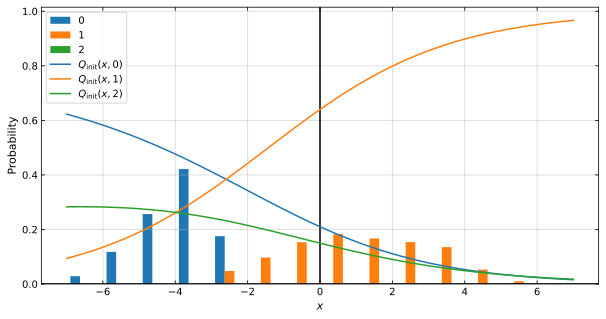

In [15]:
# m) Predict and plot the labels for the training data with the untrained neural network
all_points = stacked_points.flatten()
all_labels = np.array(range(stacked_points.shape[-1]))*np.ones(stacked_points.shape)
all_labels = all_labels.flatten()

# Convert to torch tensors
Ps = torch.tensor(all_points, dtype=torch.float32)
labels = torch.tensor(all_labels, dtype=torch.long)

fig, ax = plt.subplots(figsize=(10,5))
nice_plot(ax)

with torch.no_grad():
    predicted_labels = model.predict_label(Ps)
    ax.hist([Ps[predicted_labels == i] for i in range(3)], bins=np.arange(-7, 8, 1), density=True, label=[f"{i}" for i in range(3)], color=["C0", "C1", "C2"])

xs = torch.linspace(-7, 7, 100)
with torch.no_grad():
    for label in range(3):
        ys = torch.softmax(model(xs), dim=1)[:, label]
        ax.plot(xs, ys, label=fr"$Q_\mathrm{{init}}(x, {label})$", color=f"C{label}")

ax.legend()

fig.savefig('ex55_fig3.png')

100%|██████████| 1000/1000 [00:01<00:00, 646.27it/s]


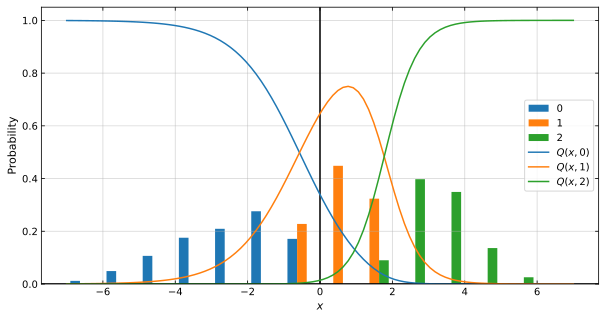

In [16]:
# n) Use the cross-entropy as a loss-function in the optimization of the parameters of the neural network behind the probability density Q.
# Plot both the Q(x,label) curves of the trained network and insert the label-predictions for all x-values in the training set.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    predicted_weights = model(Ps)
    loss = criterion(predicted_weights, labels)
    loss.backward()
    optimizer.step()

fig, ax = plt.subplots(figsize=(10,5))
nice_plot(ax)

with torch.no_grad():
    predicted_labels = model.predict_label(Ps)
    ax.hist([Ps[predicted_labels == i] for i in range(3)], bins=np.arange(-7, 8, 1), density=True, label=[f"{i}" for i in range(3)], color=["C0", "C1", "C2"])

xs = torch.linspace(-7, 7, 100)
with torch.no_grad():
    for label in range(3):
        ys = torch.softmax(model(xs), dim=1)[:, label]
        ax.plot(xs, ys, label=fr"$Q(x, {label})$", color=f"C{label}")

ax.legend()

fig.savefig('ex55_fig4.png')

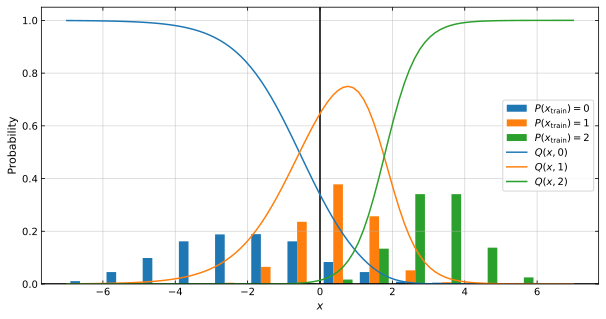

In [17]:
# o) Plot the two probabilities, P and Q, as you know them best. I.e. plot the data points for P that were used for the training,
# and plot the three probability curves, one for each label, according to the trained neural network, Q(x,label)
fig, ax = plt.subplots(figsize=(10,5))
nice_plot(ax)

ax.hist(stacked_points, bins=np.arange(-7, 8, 1), density=True, label=[fr"$P(x_\mathrm{{train}}) = {i}$" for i in range(3)], color=["C0", "C1", "C2"])

xs = torch.linspace(-7, 7, 100)
with torch.no_grad():
    for label in range(3):
        ys = torch.softmax(model(xs), dim=1)[:, label]
        ax.plot(xs, ys, label=fr"$Q(x, {label})$", color=f"C{label}")

ax.legend()

fig.savefig('ex55_fig5.png')